In [3]:
import pandas as pd
import numpy as np
from binance.client import Client
import datetime as dt
import requests
import json


In [109]:

class MartingaleBacktest:
    def __init__(self, data, initial_investment=100,initial_balance = 1000, 
                 profit_threshold=0.05, loss_threshold=0.05, multiplier=2, 
                 direction='long', leverage_allowed = False, transaction_fee = 0.001):
        """
       Initialization of the backtest.

        :param data: pandas DataFrame with historical data, must contain the 'close' column.
        :param initial_investment: Initial stake in dollars.
        :param balance: Starting balance in dollars.
        :param profit_threshold: Profit threshold (e.g., 0.05 for 5%).
        :param loss_threshold: Loss threshold (e.g., 0.05 for 5%).
        :param multiplier: Multiplier for doubling the stake after a loss.
        :param direction: Trade direction: 'long' for going up, 'short' for going down.
        :param leverage_allowed: Whether leverage is allowed (i.e., exceeding the deposit amount for a trade).
        
        """
        self.data = data.copy().reset_index(drop=True)
        self.initial_investment = initial_investment
        self.max_bet = initial_investment
        self.profit_threshold = profit_threshold
        self.loss_threshold = loss_threshold
        self.multiplier = multiplier
        self.transaction_fee = transaction_fee
        if direction.lower() not in ['long', 'short', ]:
            raise ValueError("Direction must be 'long' or 'short'")
        self.direction = direction.lower()
        self.initial_balance = initial_balance
        self.balance = initial_balance  # Начальный баланс, можно параметризовать
        self.leverage_allowed = leverage_allowed
        self.reset()

    def reset(self):
        """
        Reset backtest parameters
        """
        self.balance = self.initial_balance
        self.position_size = self.initial_investment
        self.entry_price = None
        self.profits = []
        self.drawdowns = []
        self.cumulative_profit = []
        self.buy_and_hold = self.initial_investment
        self.buy_and_hold_profit = []
        self.balance_history = []
        self.bh_balance_history = []
        self.positions = []

    def run_backtest(self):
        """
        Run the backtest
        """
        for i in range(len(self.data)):
            current_close = self.data['close'].iloc[i]
            
            # Buy-and-Hold: Покупаем в первый момент и держим до конца
            if i == 0:
                self.bh_balance_history.append(self.initial_balance*(1-self.transaction_fee))
            else:
                self.bh_balance_history.append((current_close / self.data['close'].iloc[0]) * self.balance*(1-self.transaction_fee))
                
            # Стратегия Мартингейла
            if self.entry_price is None:
                # Входим в позицию
                self.entry_price = current_close
                self.current_position_size = self.position_size
                self.balance -= self.current_position_size*self.transaction_fee
               # print(self.position_size)
                self.entry_index = i
                continue

            #Price change calc
            price_change = (current_close - self.entry_price) / self.entry_price
            if self.direction == 'short':
                price_change = -price_change 

           
            if price_change >= self.profit_threshold:
                # Take profit
                profit = self.current_position_size * self.profit_threshold*(1-self.transaction_fee)
                self.balance += profit
                self.profits.append(profit)
                self.cumulative_profit.append(profit)
                self.position_size = self.initial_investment  # Reset of bet
                self.entry_price = None
            elif price_change <= -self.loss_threshold:
                #  double bet
                loss = self.current_position_size * self.loss_threshold*(1+self.transaction_fee)
                self.balance -= loss
                self.drawdowns.append(loss)
                if self.leverage_allowed:
                    self.balance -= (self.position_size*self.multiplier - self.position_size)*self.transaction_fee
                    self.position_size = self.position_size*self.multiplier
                    
                else:
                    self.balance -= min([self.position_size*self.multiplier - self.position_size,
                                         self.balance - self.position_size])*self.transaction_fee
                    self.position_size = min([self.position_size*self.multiplier, self.balance])
                if self.position_size> self.max_bet:
                    self.max_bet = self.position_size
                self.cumulative_profit.append(-loss)
                
                self.entry_price = None
                

            self.balance_history.append(self.balance)
            self.positions.append(self.position_size)

        # Buy-and-Hold for graph
        self.buy_and_hold = (self.data['close'].iloc[-1] / self.data['close'].iloc[0]) * self.balance 

    def plot_results(self):
        """
        Visualisation
        """
        plt.figure(figsize=(14, 7))
        
        # Cumulative income Martingale
        plt.plot(self.balance_history, label='Martingale Strategy Balance', color='blue')
        
        plt.plot(self.positions, label='Martingale Strategy Positions', color='red')
        
        # Cumulative income Buy-and-Hold
        plt.plot(self.bh_balance_history, label='Buy and Hold balance', color='green')
        
        plt.title('Cumulative income: Martingale vs Buy and Hold')
        plt.xlabel('Time')
        plt.ylabel('Balance (USD)')
        plt.legend()
        plt.grid(True)
        plt.show()

    def get_results(self):
        """
        Return dictionary with backtest results
        """
        total_profit = sum(self.profits) - sum(self.drawdowns)
        max_drawdown = min(self.drawdowns) if self.drawdowns else 0
        return {
            'Final Balance': self.balance,
            'Total Profit': total_profit,
            'Max Drawdown': max_drawdown,
            'Buy and Hold Balance': self.buy_and_hold,
            'Maximum Bet': self.max_bet
            
        }


<Axes: title={'center': 'ETHUSDT'}>

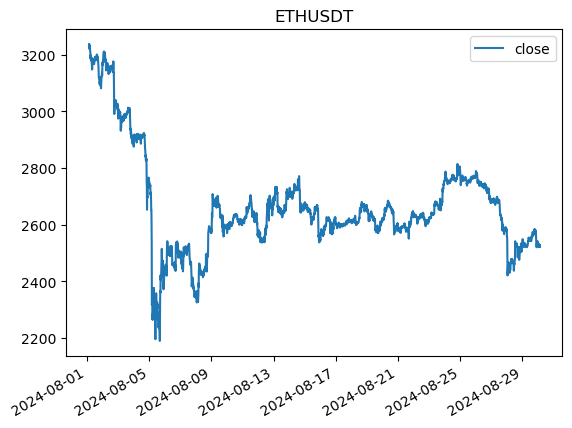

In [97]:
# USE YOUR CREDENTIALS
api_key = 'YOUR API KEY' 
api_secret = 'YPUR API SECRET'
client = Client(api_key, api_secret)

symbol = "ORDIUSDT"
interval='15m'
Client.KLINE_INTERVAL_15MINUTE 
klines = client.get_historical_klines(symbol, interval, "1 Aug,2024","30 Aug,2024")
data = pd.DataFrame(klines)
 # create colums name
data.columns = ['open_time','open', 'high', 'low', 'close', 'volume','close_time', 'qav','num_trades','taker_base_vol','taker_quote_vol', 'ignore']
            
# change the timestamp
data.index = [dt.datetime.fromtimestamp(x/1000.0) for x in data.close_time]
##data.to_csv(symbol+'.csv', index = None, header=True)
#convert data to float and plot
data=data.astype(float)
data["close"].plot(title = symbol, legend = 'close')

Итоговый баланс (Мартингейл): 986.63 USD
Общая прибыль (Мартингейл): 8.25 USD
Максимальная просадка (Мартингейл): 0.10 USD
Максимальная ставка (Мартингейл): 2560.00 USD
Итоговый баланс (Buy and Hold): 768.40 USD


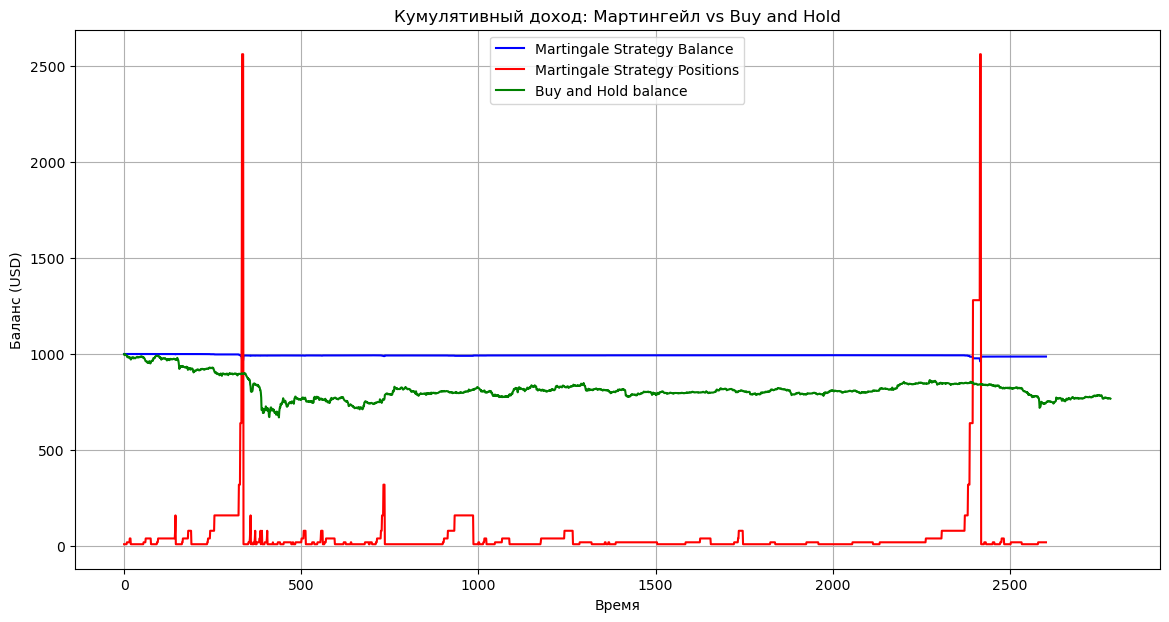

In [116]:

# Example
if __name__ == "__main__":
 
    #data = pd.read_csv('ethusdt_15min.csv', parse_dates=['timestamp'])
    #data = data.sort_values('open_time')  # Убедитесь, что данные отсортированы по времени

    # backtest initialization
    backtest = MartingaleBacktest(
        data=data,
        initial_investment=10,
        initial_balance = 1000,
        profit_threshold=0.01,
        loss_threshold=0.01,
        multiplier=2,
        leverage_allowed = True,
        direction='long'  # Или 'short' для торговли на понижение
    )

    # run
    backtest.run_backtest()

    # results
    results = backtest.get_results()
    print(f"Resulting balance (Martingale): {results['Final Balance']:.2f} USD")
    print(f"Total gain (Martingale): {results['Total Profit']:.2f} USD")
    print(f"Maximum bet (Martingale): {results['Maximum Bet']:.2f} USD")
    print(f"Resulting balance (Buy and Hold): {results['Buy and Hold Balance']:.2f} USD")

    # visualization
    backtest.plot_results()
